# simple RNN after
### バイナリ加算

iters:0
Loss:1.4878480986701665
Pred:[1 1 1 1 1 1 1 0]
True:[1 0 0 0 0 0 0 1]
20 + 109 = 254
------------
iters:100
Loss:0.8572802381813286
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 0 1 0 0]
77 + 103 = 0
------------
iters:200
Loss:1.129969471136589
Pred:[0 0 0 0 0 0 0 1]
True:[0 1 0 0 1 1 1 1]
57 + 22 = 1
------------
iters:300
Loss:0.9697455462245018
Pred:[0 0 0 0 0 0 0 1]
True:[0 1 1 0 0 0 1 0]
34 + 64 = 1
------------
iters:400
Loss:1.0223936538142597
Pred:[1 0 0 0 0 1 1 0]
True:[0 1 0 0 1 0 1 0]
67 + 7 = 134
------------
iters:500
Loss:0.8778765347584807
Pred:[0 0 0 1 0 0 0 0]
True:[0 0 0 1 0 0 1 1]
8 + 11 = 16
------------
iters:600
Loss:0.8247189156612467
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 1 1 1 0 1 1]
105 + 82 = 255
------------
iters:700
Loss:1.0221943948598806
Pred:[1 0 1 0 0 1 1 0]
True:[1 0 1 1 1 1 1 0]
83 + 107 = 166
------------
iters:800
Loss:1.1353153183582072
Pred:[0 0 1 1 0 1 1 1]
True:[0 1 1 0 1 0 0 0]
77 + 27 = 55
------------
iters:900
Loss:0.9297095720768289
Pred:[0 0 0 

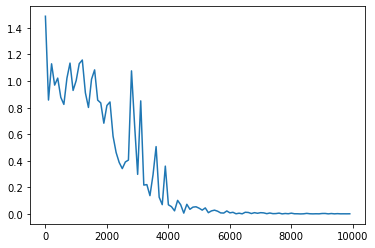

In [3]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    # 逆伝播
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] weight_init_stdやlearning_rate, hidden_layer_sizeを変更してみよう
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

iters:0
Loss:2.4777182035348795
Pred:[0 1 0 0 1 1 0 0]
True:[1 0 1 1 0 0 0 0]
52 + 124 = 76
------------
iters:100
Loss:1.4202003834037542
Pred:[1 0 1 0 0 0 1 0]
True:[0 0 1 0 1 1 1 0]
21 + 25 = 162
------------
iters:200
Loss:2.403034122682868
Pred:[1 0 1 0 1 0 0 0]
True:[1 1 0 1 0 0 1 0]
126 + 84 = 168
------------
iters:300
Loss:2.555279139200772
Pred:[1 1 0 1 1 0 1 0]
True:[0 1 1 1 0 1 0 1]
105 + 12 = 218
------------
iters:400
Loss:2.8463260024253865
Pred:[0 1 0 1 1 0 1 0]
True:[1 1 1 0 0 0 0 1]
115 + 110 = 90
------------
iters:500
Loss:1.3810731716627518
Pred:[1 1 1 1 0 0 1 0]
True:[1 0 0 1 0 0 0 0]
75 + 69 = 242
------------
iters:600
Loss:2.4950522522630596
Pred:[1 1 0 0 1 1 1 0]
True:[0 1 0 1 0 0 1 1]
41 + 42 = 206
------------
iters:700
Loss:0.9577709515935074
Pred:[1 1 1 1 1 1 1 0]
True:[1 0 0 0 1 0 1 0]
80 + 58 = 254
------------
iters:800
Loss:2.275920721205418
Pred:[1 1 1 0 0 0 0 0]
True:[0 1 0 1 1 0 0 1]
86 + 3 = 224
------------
iters:900
Loss:2.280215254196968
Pred:[1

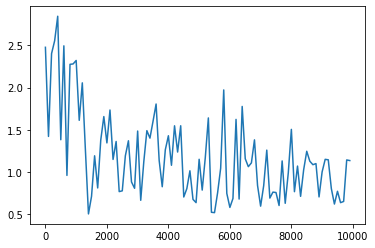

In [4]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 32
output_layer_size = 1

weight_init_std = 10
learning_rate = 0.01

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    # 逆伝播
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

ハイパーパラメータをいじった結果、学習の収束が悪くなった  
初期値の分散が大きすぎ？

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] 重みの初期化方法を変更してみよう
Xavier, He  


iters:0
Loss:1.1498240455558781
Pred:[0 0 0 0 1 0 1 0]
True:[0 1 1 1 0 1 0 0]
101 + 15 = 10
------------
iters:100
Loss:1.0200148957909985
Pred:[1 1 0 0 1 0 0 1]
True:[1 0 1 0 0 1 0 0]
54 + 110 = 201
------------
iters:200
Loss:1.125770975556634
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 1 0 1 0]
107 + 15 = 0
------------
iters:300
Loss:0.9319327058643185
Pred:[0 0 0 0 0 0 0 0]
True:[1 1 0 1 0 0 0 0]
100 + 108 = 0
------------
iters:400
Loss:0.9673886047459586
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 1 0 1 0 0 1]
84 + 85 = 255
------------
iters:500
Loss:1.137571088847017
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 0 0 0 0 1]
99 + 30 = 255
------------
iters:600
Loss:1.1320479541250554
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 1 1 0 1]
6 + 103 = 0
------------
iters:700
Loss:1.0189064268021015
Pred:[1 1 1 1 1 1 1 1]
True:[0 0 1 1 0 1 1 0]
49 + 5 = 255
------------
iters:800
Loss:0.9644807386364633
Pred:[1 1 1 1 1 1 1 1]
True:[1 1 1 1 1 0 0 0]
122 + 126 = 255
------------
iters:900
Loss:0.919516847330474
Pred:[0 0

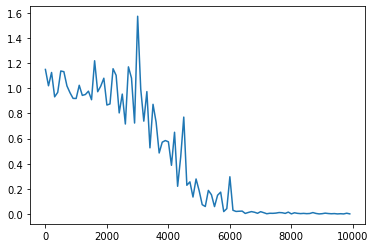

In [5]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    # 逆伝播
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

初期化をXavierに  
学習の収束がやや遅くなっている印象


iters:0
Loss:1.0883036211425905
Pred:[0 0 1 0 1 1 0 0]
True:[0 1 0 0 0 0 1 0]
44 + 22 = 44
------------
iters:100
Loss:0.9662184184696772
Pred:[0 0 1 1 0 0 1 1]
True:[1 0 1 1 0 0 0 1]
50 + 127 = 51
------------
iters:200
Loss:0.9503286838845486
Pred:[0 0 0 0 0 0 0 1]
True:[0 0 0 1 0 1 0 0]
1 + 19 = 1
------------
iters:300
Loss:1.0214307841833095
Pred:[1 0 0 1 0 1 0 1]
True:[1 0 0 1 1 0 0 0]
85 + 67 = 149
------------
iters:400
Loss:1.1011446777606109
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 1 0 1 0]
79 + 107 = 0
------------
iters:500
Loss:1.0016439653701035
Pred:[0 1 0 1 0 0 0 0]
True:[1 0 0 1 1 0 1 0]
114 + 40 = 80
------------
iters:600
Loss:0.9907289168071669
Pred:[0 1 1 0 0 0 0 0]
True:[1 0 1 0 0 0 0 0]
112 + 48 = 96
------------
iters:700
Loss:1.0590009987452957
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 1 0 0 0 0]
57 + 55 = 255
------------
iters:800
Loss:1.0776012406868483
Pred:[0 1 1 0 1 0 0 1]
True:[1 0 1 1 0 0 1 0]
125 + 53 = 105
------------
iters:900
Loss:1.0013235614571665
Pred:[0 1

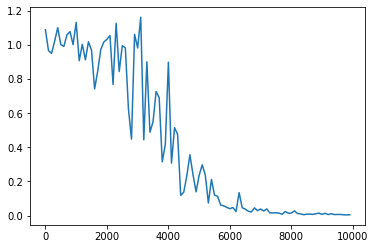

In [6]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    # 逆伝播
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

He初期化  
誤差は全体的に下がっている

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## [try] 中間層の活性化関数を変更してみよう
ReLU(勾配爆発を確認しよう)<br>
tanh(numpyにtanhが用意されている。導関数をd_tanhとして作成しよう)

iters:0
Loss:0.8919052891234035
Pred:[1 1 1 0 0 0 0 0]
True:[0 0 1 0 0 1 1 0]
29 + 9 = 224
------------
iters:100
Loss:0.8976778444578188
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 0 1 0 1 1]
3 + 104 = 255
------------
iters:200
Loss:0.8879805601384674
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 0 1 1 0 1 1]
77 + 14 = 255
------------
iters:300
Loss:0.7092173729332865
Pred:[1 0 0 0 0 1 0 1]
True:[1 0 0 0 1 1 1 1]
99 + 44 = 133
------------
iters:400
Loss:1.0303461301403407
Pred:[1 0 0 0 1 0 0 1]
True:[0 1 1 0 0 0 0 1]
69 + 28 = 137
------------
iters:500
Loss:1.0284111205840003
Pred:[0 0 0 0 1 1 0 0]
True:[1 0 1 1 1 1 1 0]
65 + 125 = 12
------------
iters:600
Loss:0.8130911851540639
Pred:[1 1 0 1 0 0 1 0]
True:[0 1 1 1 0 0 1 0]
74 + 40 = 210
------------
iters:700
Loss:1.4796798021217907
Pred:[1 0 0 1 1 0 0 0]
True:[0 1 1 1 0 1 0 0]
102 + 14 = 152
------------
iters:800
Loss:1.016541660349277
Pred:[0 0 1 0 1 0 0 0]
True:[1 1 0 0 1 1 0 0]
90 + 114 = 40
------------
iters:900
Loss:0.7502998377993348
Pred:[

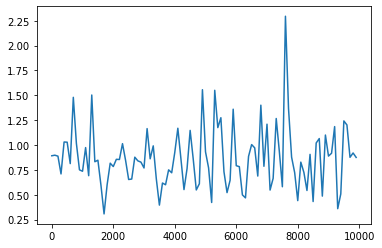

In [7]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        # z[:,t+1] = functions.sigmoid(u[:,t+1])
        z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    # 逆伝播
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

ReLUの場合  
学習が収束しなくなった                  

iters:0
Loss:1.260164418935827
Pred:[1 0 0 1 1 0 1 0]
True:[1 0 1 0 0 1 1 0]
100 + 66 = 154
------------
iters:100
Loss:1.114973361826815
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 0 0 0 1 0]
95 + 3 = 255
------------
iters:200
Loss:0.9581149453819073
Pred:[0 1 1 0 1 0 0 0]
True:[0 1 1 1 1 1 0 0]
92 + 32 = 104
------------
iters:300
Loss:0.8889739474206239
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 1 0 1 1 1 1]
105 + 70 = 255
------------
iters:400
Loss:0.9803320659210842
Pred:[1 1 1 0 0 0 1 0]
True:[1 1 0 0 1 0 0 0]
119 + 81 = 226
------------
iters:500
Loss:0.9148693954090453
Pred:[1 1 0 1 0 0 0 0]
True:[0 1 1 1 0 0 0 0]
24 + 88 = 208
------------
iters:600
Loss:0.787157697926973
Pred:[0 0 1 1 0 0 1 1]
True:[0 0 1 0 1 0 1 1]
12 + 31 = 51
------------
iters:700
Loss:0.9842772446696404
Pred:[1 0 0 0 0 1 0 1]
True:[1 0 0 0 1 1 1 1]
110 + 33 = 133
------------
iters:800
Loss:0.8030854324948967
Pred:[1 1 0 0 1 1 1 1]
True:[0 1 0 0 1 1 0 1]
55 + 22 = 207
------------
iters:900
Loss:0.9951625770250135
Pred:[

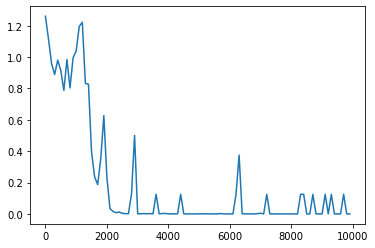

In [8]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        # z[:,t+1] = functions.sigmoid(u[:,t+1])
        # z[:,t+1] = functions.relu(u[:,t+1])
        z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    # 逆伝播
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

tanhの場合  
こちらは収束する。一度下がりきったあとも、ちょいちょい誤差があがるiterがある